In [1]:
import numpy as np 
import cv2
import pandas as pd
import glob
import torch
from PIL import Image
import matplotlib.pyplot as plt
import sys
import open3d as o3d
from utils import back_project, make_o3d_pointcloud, plot_sbs_img_depth, create_frame
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Data Prep

In [2]:
project_folder = "./data/datasets/final_project_dataset"
rgb_dir = f"{project_folder}/crazyflie-rgb-images"
pose_dir = f"{project_folder}/crazyflie-poses"

fx = 218.792814876677
fy = 224.37416225752526
cx = 322.66660990415625
cy = 243.22672826370496

In [3]:
def load_image(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def load_extrinsic_matrix(path):
    return np.loadtxt(path).reshape(4, 4)


In [4]:

rgb_files = sorted(glob.glob(f"{rgb_dir}/*.jpg"))
pose_files = sorted(glob.glob(f"{pose_dir}/*.txt"))
df = pd.DataFrame({
    "rgb_path": rgb_files,     # stores the actual path
    "pose_path": pose_files
})

In [5]:
df["image"] = df["rgb_path"].apply(load_image)
df["T"] = df["pose_path"].apply(load_extrinsic_matrix)

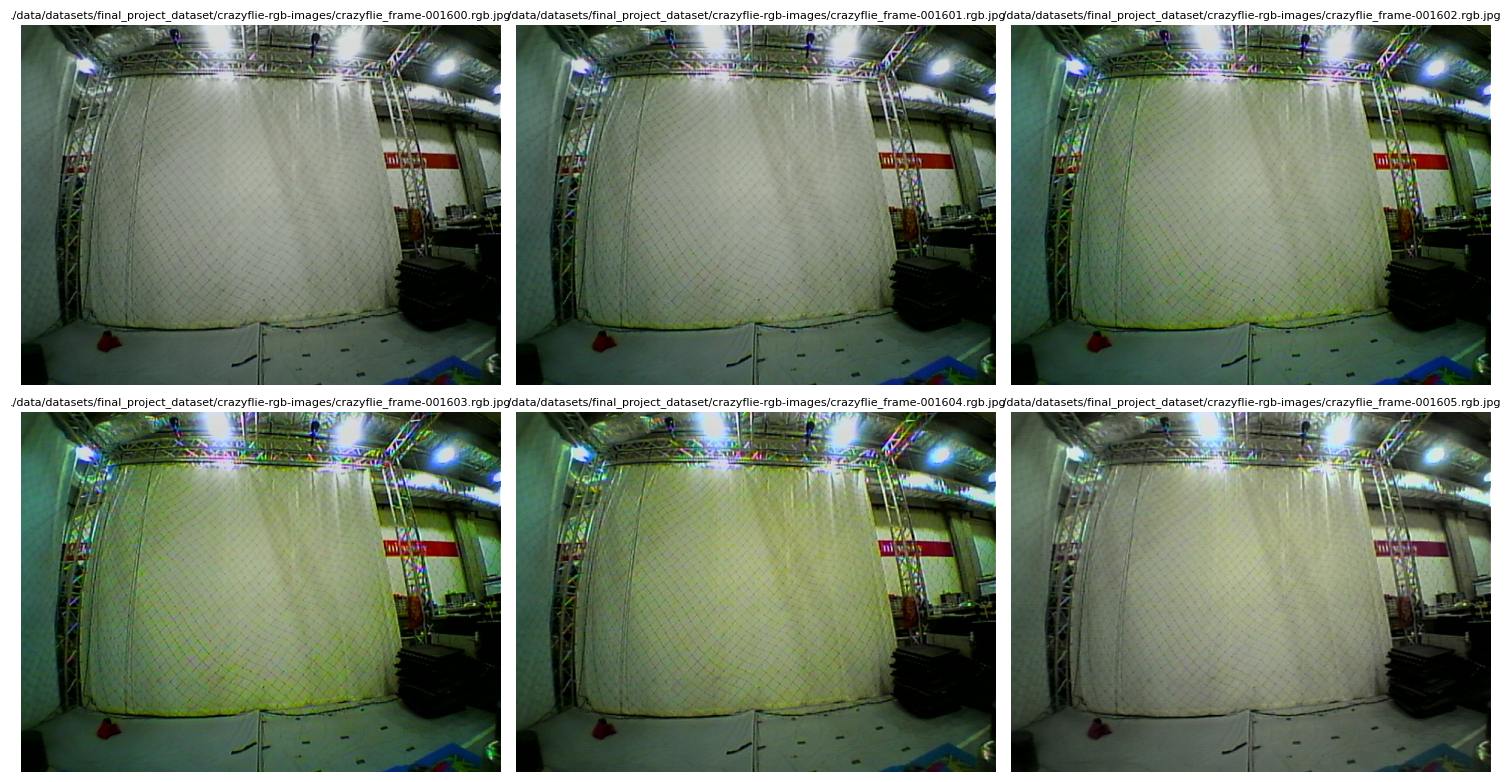

In [6]:
n = 6
cols = 3
rows = (n + cols - 1) // cols  # ceil division

fig, axes = plt.subplots(rows, cols, figsize=(15, 8))

# Flatten axes for easy indexing
axes = axes.flatten()

for i in range(n):
    ax = axes[i]
    ax.imshow(df.loc[i, "image"])
    ax.set_title(df.loc[i, "rgb_path"], fontsize=8)
    ax.axis("off")

# Hide any empty subplots
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

# Pick Image to Eval on

In [7]:
test_id = 200
img = df.loc[test_id, "image"]
T = df.loc[test_id, "T"]

# Zoe Depth

In [8]:

sys.path.insert(0, "models/ZoeDepth")
from zoedepth.models.builder import build_model
from zoedepth.utils.config import get_config
from zoedepth.utils.misc import get_image_from_url, colorize


# Device
# Device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Load model
conf = get_config("zoedepth", "eval")
model_zoe = build_model(conf)
zoe = model_zoe.to(DEVICE)
zoe.eval()

img_size [384, 512]


Using cache found in /home/mikea/.cache/torch/hub/intel-isl_MiDaS_master
/home/mikea/anaconda3/envs/mononav/lib/python3.9/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  False
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_N.pt
Loaded successfully


ZoeDepth(
  (core): MidasCore(
    (core): DPTDepthModel(
      (pretrained): Module(
        (model): Beit(
          (patch_embed): PatchEmbed(
            (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
            (norm): Identity()
          )
          (pos_drop): Dropout(p=0.0, inplace=False)
          (blocks): ModuleList(
            (0-23): 24 x Block(
              (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
              (attn): Attention(
                (qkv): Linear(in_features=1024, out_features=3072, bias=False)
                (attn_drop): Dropout(p=0.0, inplace=False)
                (proj): Linear(in_features=1024, out_features=1024, bias=True)
                (proj_drop): Dropout(p=0.0, inplace=False)
              )
              (drop_path): Identity()
              (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
              (mlp): Mlp(
                (fc1): Linear(in_features=1024, out_features=4096, bias=Tru

In [9]:

# Example: visualize first 5 poses
frames = [create_frame(df.loc[i, "T"], size=0.1) for i in range(len(df))]

# Optionally, visualize together with a point cloud
# For demo, just the frames
#o3d.visualization.draw_geometries(frames)

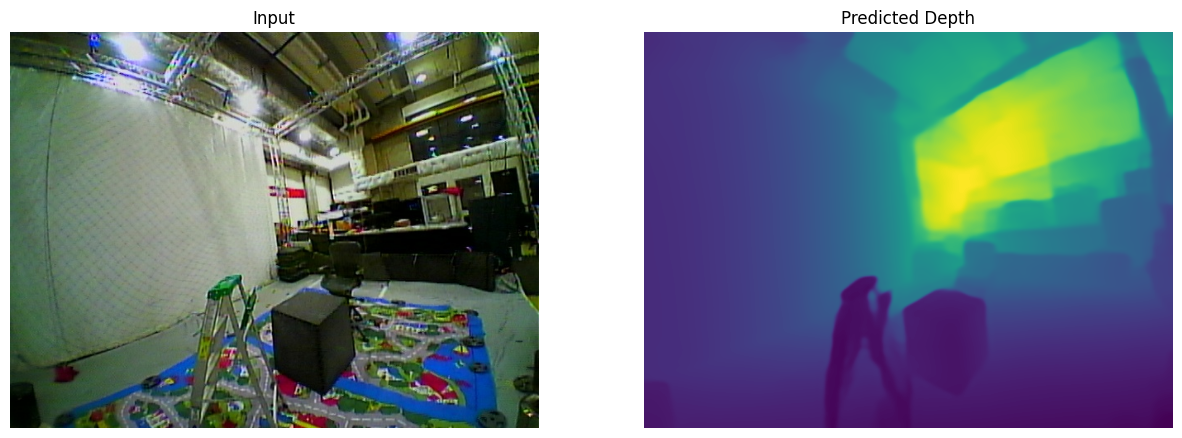

In [10]:
# Run ZoeDepth to get depth
depth_numpy = zoe.infer_pil(img)

# Colorize depth for visualization
colored_depth = colorize(depth_numpy)
#plot_sbs_img_depth(img, colored_depth)

# Generate Open3D point cloud
pcd = make_o3d_pointcloud(np.array(img), depth_numpy, T, fx, fy, cx, cy)

# Downsample to reduce number of points
pcd.voxel_down_sample(voxel_size=0.02)  # optional


# Optional: remove outliers
# cl, ind = pcd.remove_statistical_outlier(nb_neighbors=50, std_ratio=2)
# pcd = pcd.select_by_index(ind)
# Visualize
o3d.visualization.draw_geometries([pcd])
plot_sbs_img_depth(img, depth_numpy)

# DepthAnyV2

In [11]:
import cv2
import sys
import torch
sys.path.insert(0, "models/Depth-Anything-V2/metric_depth/")
from depth_anything_v2.dpt import DepthAnythingV2

model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]}
}

encoder = 'vitl'
dataset = 'hypersim'
max_depth = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DepthAnythingV2(**{**model_configs[encoder], 'max_depth': max_depth})
model.load_state_dict(
    torch.load(
        f'models/Depth-Anything-V2/metric_depth/checkpoints/depth_anything_v2_metric_{dataset}_{encoder}.pth',
        map_location=device
    )
)
model.to(device)
model.eval()

DepthAnythingV2(
  (pretrained): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-23): 24 x NestedTensorBlock(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (drop): Dropout(p=0.0, inplace=Fal

(480, 640)


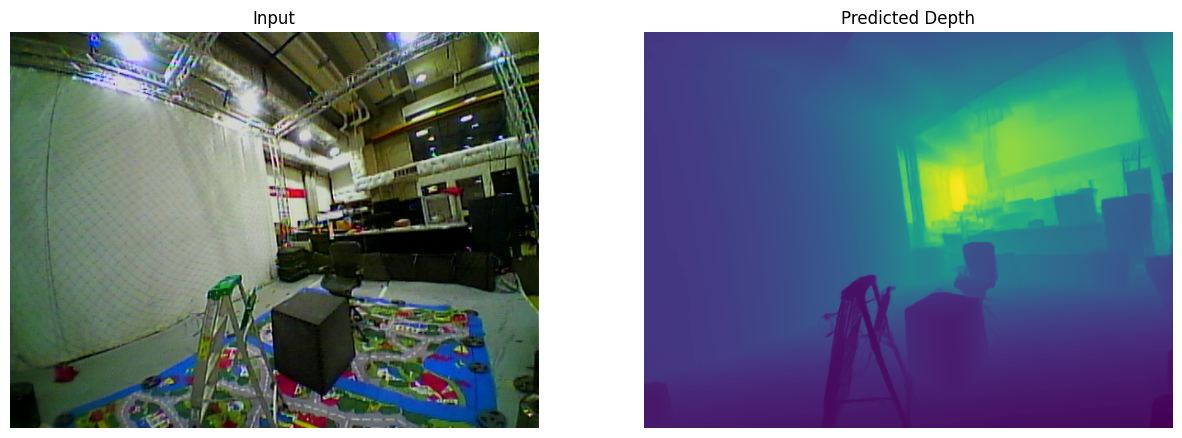

In [12]:

depth = model.infer_image(img)  # HxW depth map
print(depth.shape)
pcd = make_o3d_pointcloud(img, depth, T, fx, fy, cx, cy)
o3d.visualization.draw_geometries([pcd])
plot_sbs_img_depth(img, depth)

## Depth V3 

In [13]:
df.keys()

Index(['rgb_path', 'pose_path', 'image', 'T'], dtype='object')

In [14]:
sys.path.insert(0, "models/Depth-Anything-3/src")
from depth_anything_3.api import DepthAnything3


device = torch.device("cuda")
model = DepthAnything3.from_pretrained("depth-anything/DA3NESTED-GIANT-LARGE")
model = model.to(device=device)


[WARN ] Dependency `gsplat` is required for rendering 3DGS. Install via: pip install git+https://github.com/nerfstudio-project/gsplat.git@0b4dddf04cb687367602c01196913cde6a743d70
[INFO ] using SwiGLU layer as FFN
[INFO ] using MLP layer as FFN


[INFO ] Processed Images Done taking 0.008589744567871094 seconds. Shape:  torch.Size([1, 3, 378, 504])
[INFO ] Model Forward Pass Done. Time: 0.2286360263824463 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0009906291961669922 seconds


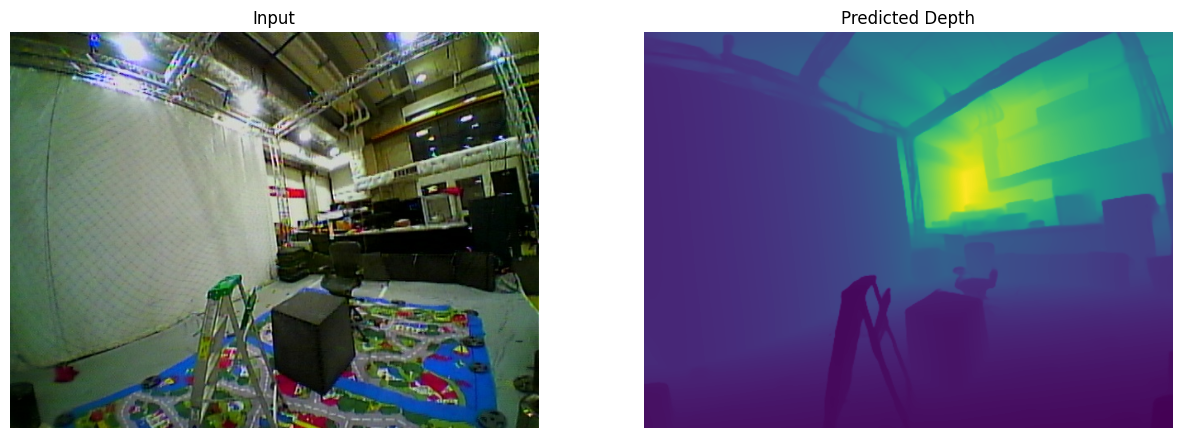

In [15]:
prediction = model.inference([img])
depth = prediction.depth[0]

# Resize depth to input image resolution
h, w = img.shape[:2]
depth = cv2.resize(depth, (w, h), interpolation=cv2.INTER_LINEAR)

pcd = make_o3d_pointcloud(img, depth, T, fx, fy, cx, cy)
o3d.visualization.draw_geometries([pcd])
plot_sbs_img_depth(img, depth)




# # prediction.processed_images : [N, H, W, 3] uint8   array
# print(prediction.processed_images.shape)
# # prediction.depth            : [N, H, W]    float32 array
# print(prediction.depth.shape)  
# # prediction.conf             : [N, H, W]    float32 array
# print(prediction.conf.shape)  
# # prediction.extrinsics       : [N, 3, 4]    float32 array # opencv w2c or colmap format
# print(prediction.extrinsics.shape)
# # prediction.intrinsics       : [N, 3, 3]    float32 array
# print(prediction.intrinsics.shape)